<a href="https://colab.research.google.com/github/pejmanrasti/FormationUnivAngers/blob/main/Jour3/Apple_detection_Transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Hands-on**: **Training via transfer learning, a UNET model for  Apple Detection**

# **U-Net (2D)**
---

<font size = 4>U-Net is an encoder-decoder network architecture originally used for image segmentation, first published by [Ronneberger *et al.*](https://arxiv.org/abs/1505.04597). The first half of the U-Net architecture is a downsampling convolutional neural network which acts as a feature extractor from input images. The other half upsamples these results and restores an image by combining results from downsampling with the upsampled images.


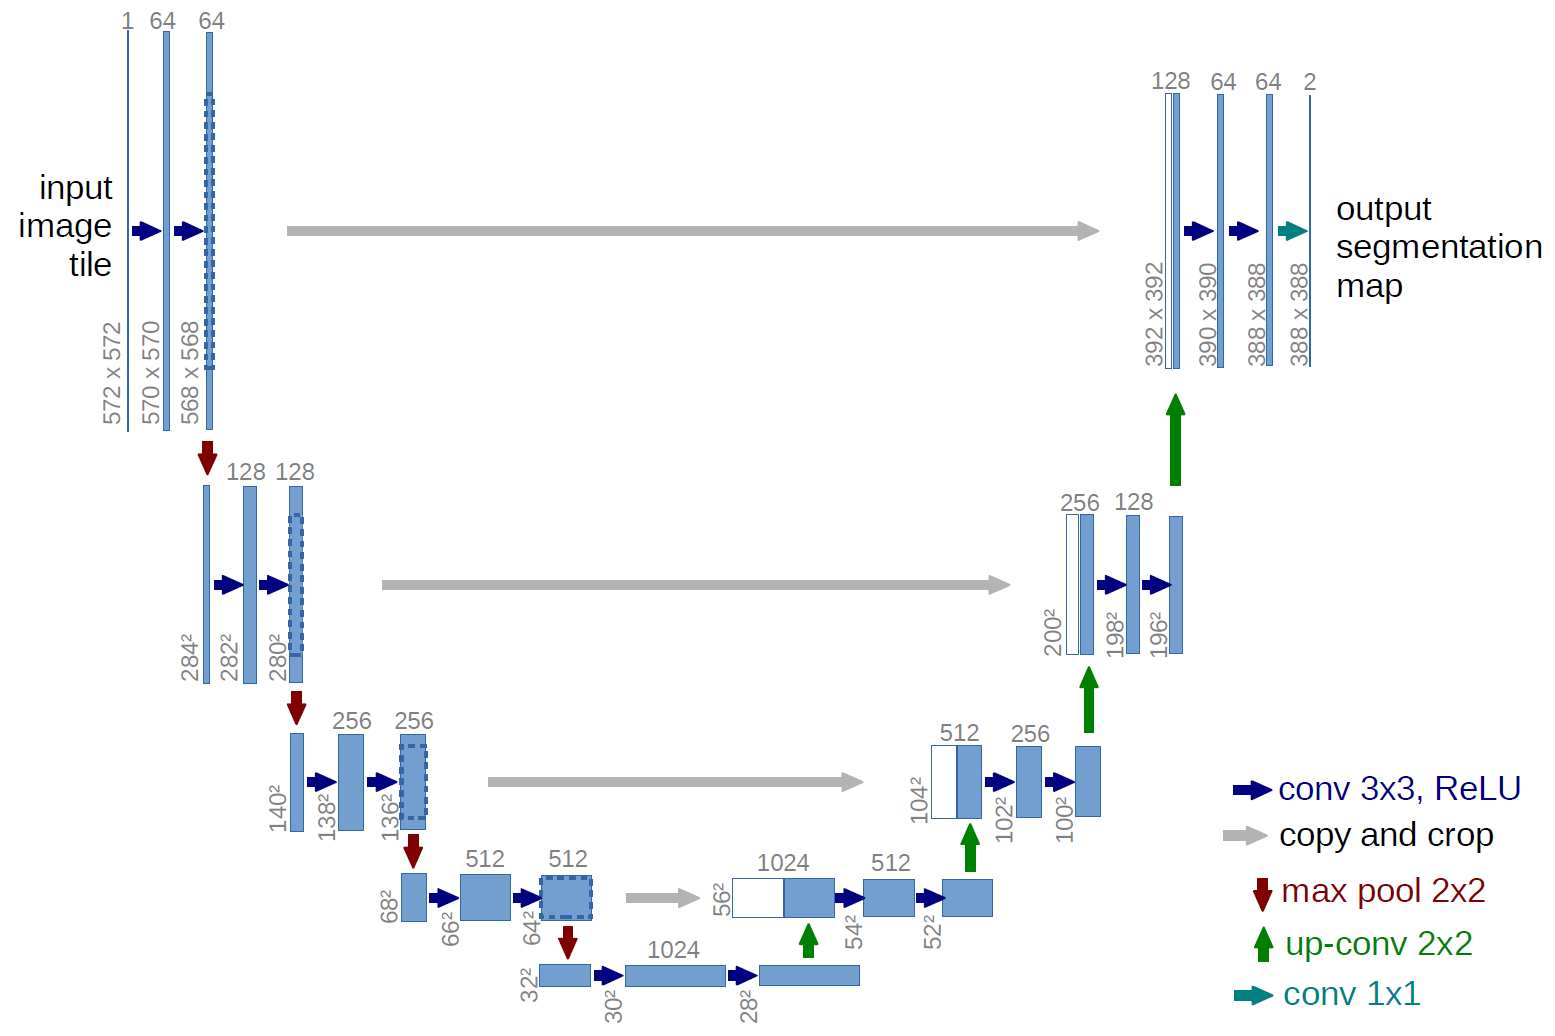


# **Step 0: Important note**

  <font size = 4> 1. Before you run the notebook, please ensure that you are logged into your Google account and have the data to process in your Google Drive.

  <font size = 4> 2. Check for GPU access: Go to **Runtime -> Change the Runtime type**


  <font size = 4> 3. If you wish to train the network using your own dataset, please change the path of your data specified in **Step 3**


<font size = 4> 4. **Download your saved model(s) from Google Drive or change the name of new trained model otherwise the saved files will be erased**


## Step 0.1: Mount your Google Drive

In [ ]:
# mount user's Google Drive to Google Colab.
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# **Step 1. Install U-Net dependencies**

In [ ]:
!pip install q keras==2.3.0
!pip install tensorflow-gpu==2.0.0


import os
import cv2
import shutil
import sys
import random
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
import h5py
from PIL import Image
from IPython.display import display, HTML 
from itertools import chain
from tqdm import tqdm_notebook, tnrange
# **********************************************
from keras.optimizers import Adam, RMSprop
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda, Reshape, Permute, Activation
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
from keras.callbacks import TensorBoard
import tensorflow as tf
from keras.models import Model, load_model
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose,UpSampling2D
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.layers.merge import concatenate, add
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam
from keras.losses import binary_crossentropy
from keras.models import load_model


from skimage.io import imread, imshow, concatenate_images
from skimage import color
from skimage.transform import resize
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img



%matplotlib inline
!pip install -U segmentation-models

     |████████████████████████████████| 378kB 7.2MB/s 
     |████████████████████████████████| 51kB 7.5MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3
     |████████████████████████████████| 380.8MB 37kB/s 
     |████████████████████████████████| 450kB 53.0MB/s 
     |████████████████████████████████| 3.8MB 54.3MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7542 sha256=d33c98840493fa26fffdefc82f3e30d12d60f4e6473ed3c09333625808ce7905
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow 2.3.0 has requirement gast==0.3.3, but you'll have gast 0.2.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorboard<3,>=2.3.0, but you'll have tensorboard 2.0.2 which is incompatible.
ERROR: tensorflow 2.3.0 has requirement tensorflow-estimator<2.4.0,>=2.3.0, but you'll have tensorflow-esti

Using TensorFlow backend.


In [ ]:
import segmentation_models as sm

if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")
    

seed = 42
random.seed = seed
np.random.seed = seed

Segmentation Models: using `keras` framework.
Default GPU Device: /device:GPU:0


# **Step 2: Functions**

In [ ]:
def background(mask):
    backgr = np.logical_not(mask)
    return backgr

def rgb_to_gray(img):
        gray = np.zeros(img.shape)
        R = np.array(img[:, :, 0])
        G = np.array(img[:, :, 1])
        B = np.array(img[:, :, 2])        

        for i in range(3):
           gray[:,:,i] = R *.299 + G *.587 + B *.114

        return gray 
    
def show_images(images,titles=None):
    """Display a list of images"""
    n_ims = len(images)
    if titles is None: titles = ['(%d)' % i for i in range(1,n_ims + 1)]
    fig = plt.figure(figsize=(20, 10))
    n = 1
    for image,title in zip(images,titles):
        a = fig.add_subplot(1,n_ims,n) # Make subplot
        a.grid(False)
        #plt.imshow(image, cmap=plt.cm.nipy_spectral)
        plt.imshow(image, cmap = plt.cm.gray)
        a.set_title(title)
        n += 1
    plt.show()

def dice_coef(y_true, y_pred):
    eps = 1e-6
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection) / (K.sum(y_true_f * y_true_f) + K.sum(y_pred_f * y_pred_f) + eps)

def performance(y_pred, y_true):
    TP = sum(sum(y_pred * y_true))
    FP = sum(sum(y_pred - y_pred * y_true))
    FN = sum(sum(y_true - y_pred * y_true))
    TPR = TP/(TP+FN)
    PPV = TP/(TP+FP)
    return (TPR, PPV)


# **Step3: Reading DATA**

In [ ]:
pickle_in = open("/content/gdrive/MyDrive/Longlifetraining/Apple_detection/RGB_dataset_apples_for_deepJ.pickle","rb")
RGB_image = pickle.load(pickle_in)

pickle_in = open("/content/gdrive/MyDrive/Longlifetraining/Apple_detection/BW_labels_dataset_apples_for_deepJ.pickle","rb")
Mask = pickle.load(pickle_in)
Mask=np.array(Mask)


print('RGB images shape is',RGB_image.shape)
print('Masks shape is' ,Mask.shape)

RGB images shape is (670, 224, 224, 3)
Masks shape is (670, 224, 224, 1)


# **Step 4: Shuffle, Split DATA and Display images and masks**

In [ ]:
#shuffle
idx = np.random.permutation(len(RGB_image))
RGB_image, Mask = RGB_image[idx], Mask[idx]

#train data
RGB_image_train=RGB_image[:500] 
Mask_train=Mask[:500]

#validation data
RGB_image_valid=RGB_image[500:600]
Mask_valid=Mask[500:600]

#test data
RGB_image_test=RGB_image[600:670]
Mask_test=Mask[600:670]

print('Total number of Training DATA: ', len(RGB_image_train))
print('Total number of Validation DATA: ', len(RGB_image_valid))
print('Total number of test DATA: ', len(RGB_image_test))

Total number of Training DATA:  500
Total number of Validation DATA:  100
Total number of test DATA:  70


## Show Images

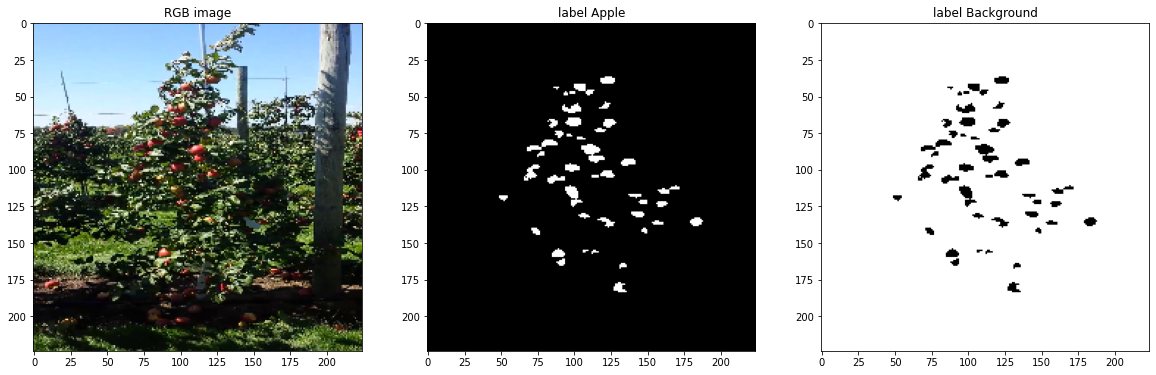

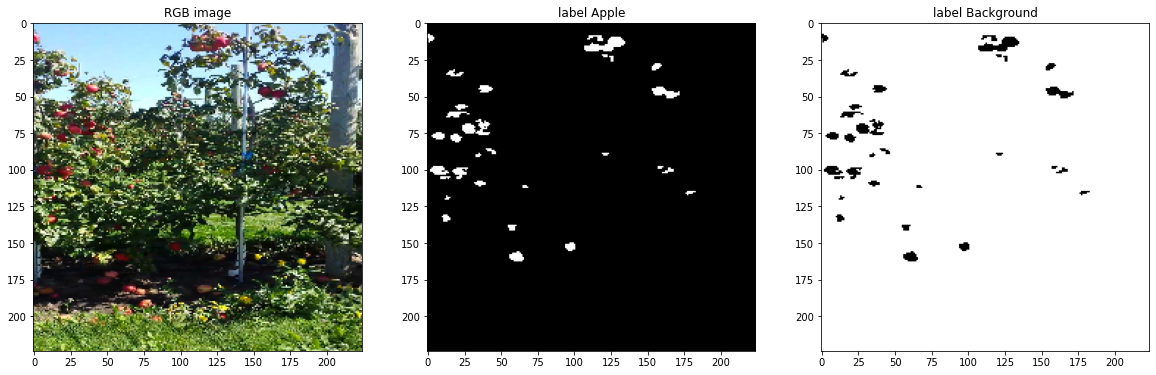

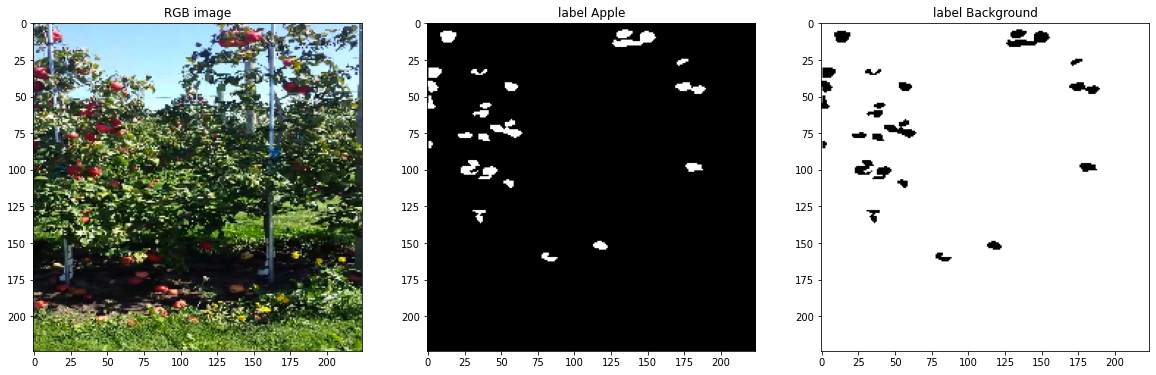

In [ ]:
ix = 10
show_images(images = [RGB_image_train[ix,:,:,:], Mask_train[ix,:,:,0], background(Mask_train[ix,:,:,0])], 
            titles = ['RGB image', 'label Apple', 'label Background'])
show_images(images = [RGB_image_valid[ix,:,:,:], Mask_valid[ix,:,:,0], background(Mask_valid[ix,:,:,0])], 
            titles = ['RGB image', 'label Apple', 'label Background'])
show_images(images = [RGB_image_test[ix,:,:,:], Mask_test[ix,:,:,0], background(Mask_test[ix,:,:,0])], 
            titles = ['RGB image', 'label Apple', 'label Background'])

# **Step 5: Perform Data augmentation: albumentation library**


In [ ]:
from albumentations import (VerticalFlip, HorizontalFlip, Flip, RandomRotate90, Rotate, ShiftScaleRotate, CenterCrop, OpticalDistortion,                              
                            ElasticTransform, JpegCompression, HueSaturationValue, GridDistortion,
                            RGBShift, RandomBrightness, RandomContrast, Blur, MotionBlur, MedianBlur, GaussNoise, CLAHE, ChannelShuffle, 
                            InvertImg, RandomGamma, ToGray, PadIfNeeded, RandomCrop, Compose, Transpose, RandomSizedCrop, OneOf, Normalize)

import segmentation_models as sm

In [ ]:
IMG_HEIGHT=224
IMG_WIDTH=224
IMG_CHANNELS=3
LABEL_CHANNELS=1

aug_proportion = 4 #how much are we increasing the data set example 4 means each image will have 4 correpondants synthetic images

n_aug = int(len(RGB_image_train) * aug_proportion)
X_aug = np.zeros((n_aug, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
Y_aug = np.zeros((n_aug, IMG_HEIGHT, IMG_WIDTH, LABEL_CHANNELS), dtype=np.bool)


aug = Compose([HorizontalFlip(p=0.8),
               VerticalFlip(p=0.7),
               RandomBrightness(p=0.8, limit=0.2),
               RandomContrast(p=0.5, limit=0.2),
               RandomRotate90(p=0.6),
            ])


for i in range(0,int(len(RGB_image_train))):
        j=aug_proportion*i
        for z in range(0,aug_proportion):
              step=(z+j)
              augmented = aug(image=np.float32(RGB_image_train[i]), mask=Mask_train[i]*1)
              X_aug[step] = augmented['image']
              Y_aug[step] = augmented['mask']
  


RGB_image_train_aug = np.append(RGB_image_train, X_aug, axis=0)
Mask_train_aug = np.append(Mask_train, Y_aug, axis=0)

#shuffling
idx = np.random.permutation(len(RGB_image_train_aug))
RGB_image_train_aug, Mask_train_aug = RGB_image_train_aug[idx], Mask_train_aug[idx]

print("Training images (size+shape): ", RGB_image_train_aug.shape)
print("Training masks (size+shape): ", Mask_train_aug.shape)

X_train:  (2500, 224, 224, 3)
Y_train:  (2500, 224, 224, 1)


## Show Images

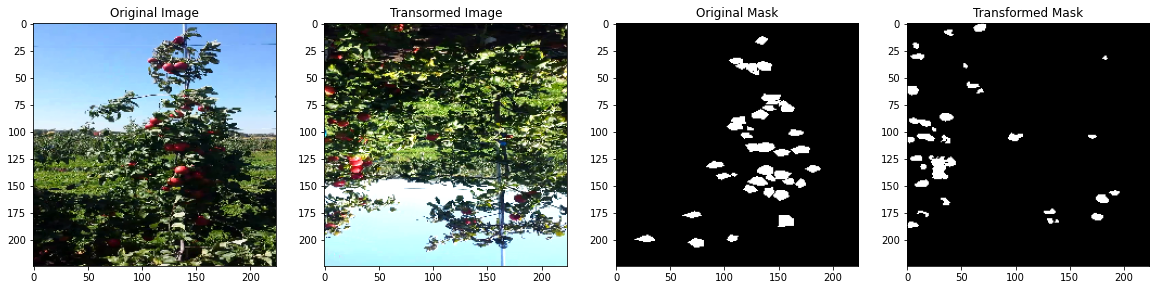

In [ ]:
ix = 0 #index for real images
ixx=3 # index for augmented images
show_images(images = [RGB_image_train[ix,:,:,:], X_aug[ixx,:,:,:], Mask_train[ix,:,:,0],  Y_aug[ixx,:,:,0]],
            titles = ['Original Image', 'Transormed Image', 'Original Mask', 'Transformed Mask'])

# **Step 6: Defining U-Net model**
--- 

## A. Model

In [ ]:
BACKBONE = 'vgg19'
model = sm.Unet(backbone_name=BACKBONE, encoder_weights='imagenet', activation='sigmoid')

80142336/80134624 [==============================] - 2s 0us/step


## B. Loss

In [ ]:
Loss_function=binary_crossentropy

 ## C. Metrics

In [ ]:
metrics_list = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5), dice_coef, 'binary_accuracy']

 ## D. Callbacks

In [ ]:
from tensorflow import keras
from keras.callbacks import LearningRateScheduler

class LossHistory_(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.lr = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.lr.append(exp_decay(len(self.losses)))
        print('lr:', exp_decay(len(self.losses)))

def exp_decay(epoch):
    initial_lrate = 0.1
    k = 0.1
    lrate = initial_lrate * np.exp(-k*epoch)
    return lrate

# learning schedule callback
loss_history_ = LossHistory_()
lrate_ = LearningRateScheduler(exp_decay)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=1, mode='auto', min_delta=0.0001, cooldown=5, min_lr=0.0001)
Name_of_the_model_saved='/content/gdrive/MyDrive/Longlifetraining/Apple_detection/AppleDetection_best_model_pretrained_test1.h5' #You can should this part of the path /content/gdrive/MyDrive/Longlifetraining/Apple_detection
early = EarlyStopping(monitor="val_loss", mode="min", patience=15)
checkpoint = ModelCheckpoint(Name_of_the_model_saved, verbose=1, save_best_only=True)
callbacks_list = [loss_history_, lrate_,checkpoint, early, reduceLROnPlat]


 ## E. Model Parameters

In [ ]:
BATCH_SIZE = 5
EPOCHS = 100 
optim = Adam(0, decay = 1e-6)

 ## F. Model train

In [ ]:
model.compile(optim, loss = Loss_function , metrics=metrics_list)
history = model.fit(RGB_image_train, Mask_train, batch_size=BATCH_SIZE, epochs=EPOCHS, validation_data=(RGB_image_valid, Mask_valid),verbose=1,callbacks=callbacks_list)

Train on 500 samples, validate on 100 samples
Epoch 1/100
500/500 [==============================] - 21s 43ms/step - loss: 0.1296 - iou_score: 4.1562e-04 - f1-score: 7.9807e-04 - dice_coef: 0.0568 - binary_accuracy: 0.9686 - val_loss: 0.4526 - val_iou_score: 1.5780e-09 - val_f1-score: 1.5780e-09 - val_dice_coef: 0.0976 - val_binary_accuracy: 0.9711
lr: 0.09048374180359596

Epoch 00001: val_loss improved from inf to 0.45257, saving model to AppleDetection_best_model.h5
Epoch 2/100
500/500 [==============================] - 12s 24ms/step - loss: 0.1168 - iou_score: 1.7435e-09 - f1-score: 1.7435e-09 - dice_coef: 0.0614 - binary_accuracy: 0.9741 - val_loss: 0.1321 - val_iou_score: 1.5780e-09 - val_f1-score: 1.5780e-09 - val_dice_coef: 0.0973 - val_binary_accuracy: 0.9711
lr: 0.0818730753077982

Epoch 00002: val_loss improved from 0.45257 to 0.13210, saving model to AppleDetection_best_model.h5
Epoch 3/100
500/500 [==============================] - 12s 24ms/step - loss: 0.0953 - iou_score: 

# **Step 7: Assessement**

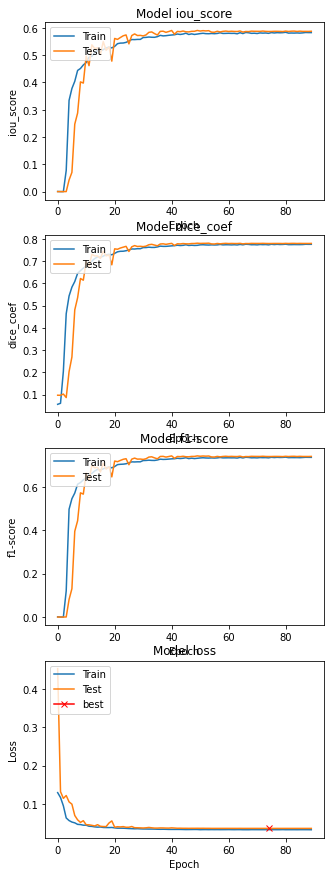

In [ ]:
# Plot training & validation iou_score values
plt.figure(figsize=(5, 15))
plt.subplot(411)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left') 


plt.subplot(412)
plt.plot(history.history['dice_coef'])
plt.plot(history.history['val_dice_coef'])
plt.title('Model dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left') 


plt.subplot(413)
plt.plot(history.history['f1-score'])
plt.plot(history.history['val_f1-score'])
plt.title('Model f1-score')
plt.ylabel('f1-score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')

# Plot training & validation loss values
plt.subplot(414)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test','best'], loc='upper left')
plt.show()

In [ ]:
print("Val loss is ", np.min(history.history["val_loss"]))
print("Val Dice coeff is",np.max(history.history["val_dice_coef"]))
print("Val iou coeff is ", np.max(history.history["val_iou_score"]))
print("Val f1 coeff is ", np.max(history.history["val_f1-score"]))

Val loss is  0.03643300291150808
Val Dice coeff is 0.7800346612930298
Val iou coeff is  0.5902773141860962
Val f1 coeff is  0.7419905662536621


 ## A. Evaluation on Test DATA - method 1

In [ ]:
# load the best model
from keras.models import Model, load_model
Name_of_the_model_saved='/content/gdrive/MyDrive/Longlifetraining/Apple_detection/AppleDetection_best_model_pretrained_test1.h5' #You can should this part of the path /content/gdrive/MyDrive/Longlifetraining/Apple_detection
model = load_model(Name_of_the_model_saved, custom_objects={'dice_coef': dice_coef, 'iou_score': sm.metrics.IOUScore(threshold=0.5), 'f1-score': sm.metrics.FScore(threshold=0.5)})

In [ ]:
# Evaluating the trained model
eval_test = model.evaluate(RGB_image_test, Mask_test)

70/70 [==============================] - 2s 31ms/step


In [ ]:
#print performances of the model on test images
print("Test Loss = " + str(eval_test[0]))
print("Test Metric = ",str(eval_test[1]),str(eval_test[2]),str(eval_test[3]))

Test Loss = 0.032966732872383935
Test Metric =  0.590951144695282 0.7428600192070007 0.782540500164032


 ## B. Evaluation on Test DATA - method 2

In [ ]:
Mask_test_pred_int= model.predict(RGB_image_test, verbose=2) #predict the masks, the output is a probability map

In [ ]:
Treshold=0.5
Mask_test_pred_int_thres = (Mask_test_pred_int >Treshold).astype(np.uint8) #convert the probability map to an unit8 image using the threshold chosen

In [ ]:
#compute the True positive  and recall
True_positive = np.zeros((Mask_test.shape[0]))
Recall = np.zeros((Mask_test.shape[0]))
for ix in range(Mask_test.shape[0]):
    True_positive[ix], Recall[ix] = performance(Mask_test_pred_int_thres[ix], Mask_test[ix])

In [ ]:
#print performances of the model on test images
print("Mean True Positive:", True_positive.mean())
print("Mean Recall:",Recall.mean())
print("max True Positive:",True_positive.max())
print("max Recall:",Recall.max())
print("min True Positive:",True_positive.min())
print("min Recall:",Recall.min())

Mean True Positive: 0.7012479624577931
Mean Recall: 0.7566140179123197
max True Positive: 0.8992537260055542
max Recall: 0.888561487197876
min True Positive: 0.44565218687057495
min Recall: 0.1981566846370697


 # **Step 8: Inference on unlabled data and save generated masks**

In [ ]:
#Predict the masks of new images
Path_new_images=''
Path_to_save_masks=''
New_images=
Masks= model.predict(New_images, verbose=1)
Treshold=0.5
Mask_thres = (Masks >Treshold).astype(np.uint8)

for j in range(0,len(Mask_thres)):
   img1 = Masks[j, :, :, 0]
   fig = plt.imshow(~img1)
   plt.axis('off')
   fig.axes.get_xaxis().set_visible(False)
   fig.axes.get_yaxis().set_visible(False)
   plt.savefig(Path_to_save_masks+"{}.png".format(j), bbox_inches='tight', pad_inches = 0)